## Introduction

This is my first ML project that I mostly coded myself from start to finish. The goal for me was to create a full ML pipeline that includes:
- Data manupulation with pandas. Data analysis and extraction of relevant features.
- Dataset cleaning with scikit-learn for XGBoost algorithm.
- GridSearchCV for hyperparamter tuning.


##  Useful recources:
During my research for this competition, I found the following references very useful. I'd advise every beginner to have a peek into these articles:
- Amazing walkthrough and good overview over the most important issues to tackle: <br>https://towardsdatascience.com/wrangling-through-dataland-modeling-house-prices-in-ames-iowa-75b9b4086c96
- Hands-on explanation how to perform hyperparameter tuning for different ML algorithms (including XGBoost): <br>https://towardsdatascience.com/beyond-grid-search-hypercharge-hyperparameter-tuning-for-xgboost-7c78f7a2929d


## Contents

1. Importing libaries and loading Data
2. Exploring the dataset (correlation and skew)
3. Analyzing features with missing values
4. Feature engineering
5. Data transformation
6. Modeling, training and hyperparameter tuning
8. Inference

## 1. Importing libaries and loading Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import norm, skew
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
#Loading train and test_data
data_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
data_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## 2. Exploring the train set (correlation and skew)

<AxesSubplot:title={'center':'Correlation matrix of numerical features'}>

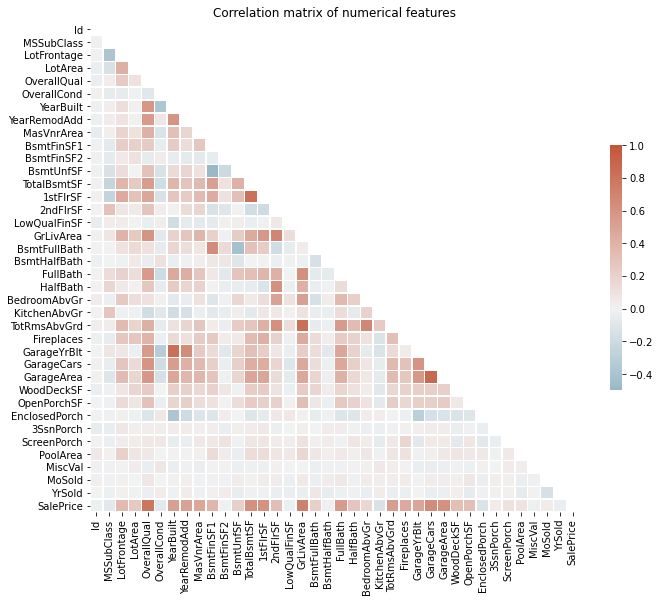

In [2]:
#visualizing correlation matrix to find dependent features
housing = data_train.copy()
corr_matrix = housing.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Add title
plt.title("Correlation matrix of numerical features")
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In order to speed up training later, I will remove some features. If the correlation between two features is high (>0.8) one of them can be dropped because they don't add much more information. <br>

The following features will be removed (correlation coefficient values see next cell): 
- **'GarageYrBlt'**
- **'1stFlrSF'**
- **'TotRmsAbvGrd'**
- **'GarageArea'**

In [3]:
# print out feature combinations with high correlation coefficient
print("Correlation coefficient 'GarageYrBlt' / 'YearBuilt': '{:.1%}".format(corr_matrix.loc['GarageYrBlt', 'YearBuilt']))
print("Correlation coefficient '1stFlrSF' / 'TotalBsmtSF': '{:.1%}".format(corr_matrix.loc['1stFlrSF', 'TotalBsmtSF']))
print("Correlation coefficient 'TotRmsAbvGrd' / 'GrLivArea': '{:.1%}".format(corr_matrix.loc['TotRmsAbvGrd', 'GrLivArea']))
print("Correlation coefficient 'GarageArea' / 'GarageCars': '{:.1%}".format(corr_matrix.loc['GarageArea', 'GarageCars']))

Correlation coefficient 'GarageYrBlt' / 'YearBuilt': '82.6%
Correlation coefficient '1stFlrSF' / 'TotalBsmtSF': '82.0%
Correlation coefficient 'TotRmsAbvGrd' / 'GrLivArea': '82.5%
Correlation coefficient 'GarageArea' / 'GarageCars': '88.2%


Next step is to check how strong the correlation between **'SalePrice'** and the other features is. All features with | correlation coefficient | < 0.2 are removed to speed up training:
- **BedroomAbvGr**                  0.168213
- **ScreenPorch**                   0.111447
- **PoolArea**                      0.092404
- **MoSold**                        0.046432
- **3SsnPorch**                     0.044584
- **BsmtFinSF2**                   -0.011378
- **BsmtHalfBath**                 -0.016844
- **MiscVal**                      -0.021190
- **Id**                           -0.021917
- **LowQualFinSF**                 -0.025606
- **YrSold**                       -0.028923
- **OverallCond**                  -0.077856
- **MSSubClass**                   -0.084284
- **EnclosedPorch**                -0.128578
- **KitchenAbvGr**                 -0.135907

<AxesSubplot:ylabel='SalePrice'>

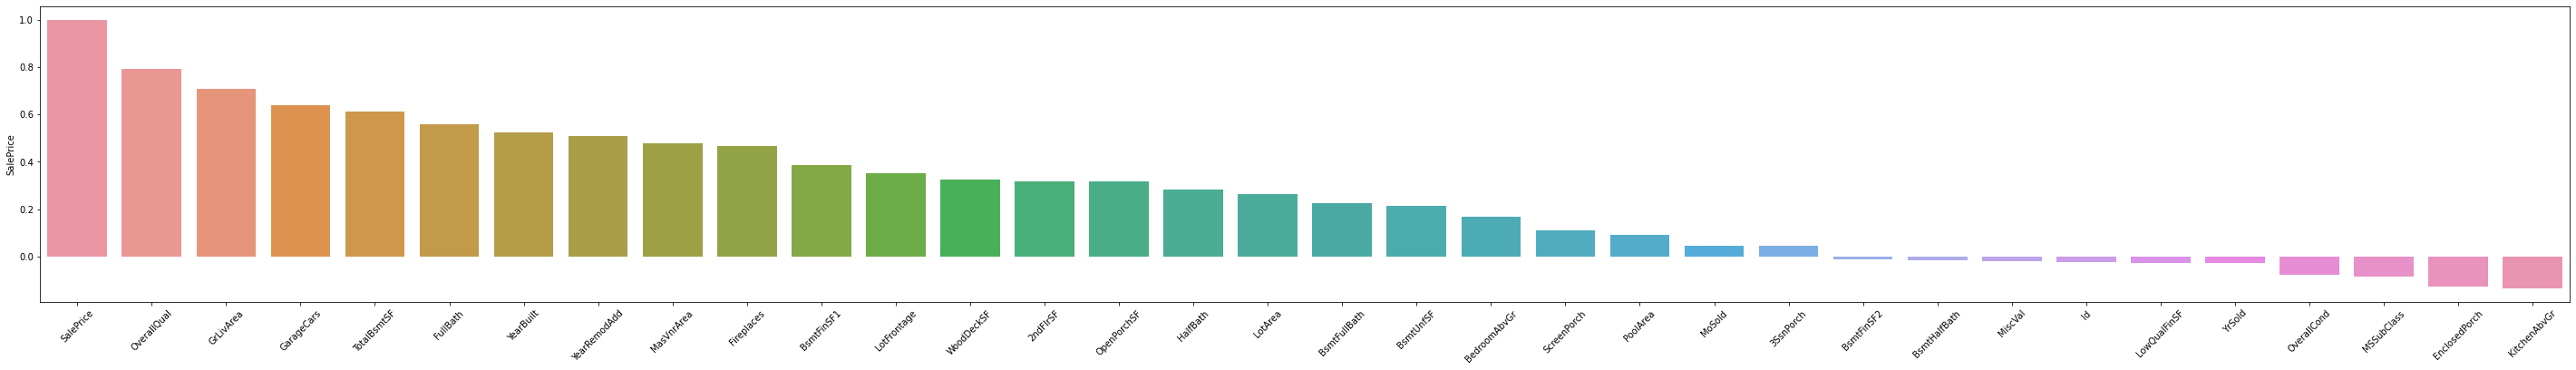

In [4]:
# Visualize correlation of columns to SalePrice
corr_matrix = corr_matrix.drop('GarageYrBlt')
corr_matrix = corr_matrix.drop('1stFlrSF')
corr_matrix = corr_matrix.drop('TotRmsAbvGrd')
corr_matrix = corr_matrix.drop('GarageArea')
plt.figure(figsize=(50,6))
plt.xticks(rotation=45)
sns.barplot(x=corr_matrix["SalePrice"].sort_values(ascending=False).index, y=corr_matrix["SalePrice"].sort_values(ascending=False))

**'SalePrice'** column needs to be removed from training set before training! All revelant feature indexes are saved in **relevant_num_features**.

In [5]:
# Remaining relevant numerical features are saved in relevant_num_features
# 'SalePrice' needs to be dropped!
corr_matrix = corr_matrix.drop('SalePrice')
relevant_num_features = corr_matrix['SalePrice'].sort_values(ascending=False).loc[:'BsmtUnfSF'].index
relevant_num_features

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1',
       'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath',
       'LotArea', 'BsmtFullBath', 'BsmtUnfSF'],
      dtype='object')

Another important issue to check is if the dataset shows skew. It can be seen that the target variable **'SalePrice'**  had extreme high values (a long right-tail) and was not distributed normally. In other words it shows positive skew (Skewness = 1.88).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 1.882876
Kurtosis: 6.536282


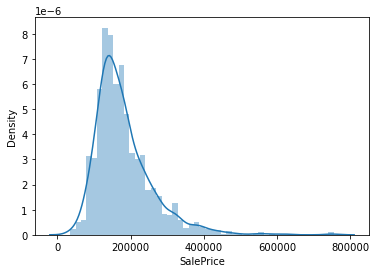

In [6]:
sns.distplot(housing['SalePrice'])
print("Skewness: %f" % housing['SalePrice'].skew())
print("Kurtosis: %f" % housing['SalePrice'].kurt())

To improve the accuracy it is better to normalize the target variable to reach a normal distribution. A posible way is to use natural log-transformation. This wil be done later in this notebook at point **5. Data transformation**:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


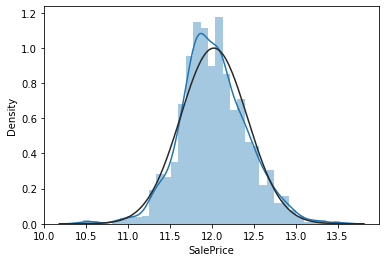

In [7]:
# Fixing skew by natural log-transformation of “SalePrice”
housing['SalePrice'] = np.log1p(housing['SalePrice'])
sns.distplot(housing['SalePrice'], fit=norm);

It's also possible to fix the scew of the other numerical features. However, I'll have a look into it in the next version of this notebook.

## 3. Analyzing features with missing values
Next, I check which features of the dataset can be removed because they don't contain enough data. For this we calculate the percentage of missing values of each column (**nan_percentage**) and show the ten highest values:

In [8]:
#Calculating percentage of empty values in each column
n_nan = []
for col in housing.columns:
    n_nan.append(int(housing[col].isna().sum(axis=0))/len(housing.index))
nan_percentage = pd.DataFrame(n_nan, index = housing.columns)

# showing the ten highest features with NaN values
nan_percentage = nan_percentage.iloc[:,0].sort_values(ascending=False)
nan_percentage[:10]

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageCond      0.055479
GarageType      0.055479
GarageFinish    0.055479
Name: 0, dtype: float64

It turned out all features with many mising values are categorical features. The following features with more than 50% missing values will be collected in a list (**low_relevant_cat**) in order to drop them from the dataset later:
- **'PoolQC'**
- **'MiscFeature'**
- **'Alley'**
- **'Fence'**

In [9]:
# Saving categorical features with >50% missing values in list
# so they can be dropped later
low_relevant_cat = nan_percentage[:4].index
low_relevant_cat

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], dtype='object')

## 4. Feature Engineering

I read that adding a feature which sums the total area (= **'TotalSF'**) will improve the score. For this I have to add a feature to the train and test dataset:

In [10]:
data_train['TotalSF'] = data_train['TotalBsmtSF'] + data_train['1stFlrSF'] + data_train['2ndFlrSF']
data_test['TotalSF'] = data_test['TotalBsmtSF'] + data_test['1stFlrSF'] + data_test['2ndFlrSF']

## 5. Data transformation
The following transformations were performed on the train and test data:
- Creating natural log normalized label vector **y_train** for the training set and remove 'SalePrice' from training
- Drop low relevant categorical features and only pick highly relevant numerical features of the train and test dataset
- Create pipeline to prepare data for ML algorithm. Impute missing numerical values with median. Standard scale numerical features. Impute missing categorical values with '-1'. One-hot-encode categorical features.

In [11]:
# Creating label vector y_train and remove it from the training set
# Labels are natural log normalized in order to reduce scew of dataset
y_train = np.log1p(data_train['SalePrice'])
data_train = data_train.drop('SalePrice', axis = 1)

# Creating helper function to select relevant features dataset
def select_relevant_data(df,relevant_num_features,low_relevant_cat):
    # devide data into numerical and categorical data
    df_cat = df.select_dtypes(include=object)
    df_num = df.select_dtypes(include=np.number)
    # drop categorical features with low relevance (>50 % missing values)
    df_cat = df_cat.drop(low_relevant_cat, axis = 1)
    # pick numerical feautres with high relevance
    df_num = df_num.loc[:,relevant_num_features]
    # return transformed dataset (only relevant features)
    return pd.concat([df_cat, df_num], axis=1)

# cleaning data from train and test_set using helper function
X_train = select_relevant_data(data_train,relevant_num_features,low_relevant_cat)
X_test = select_relevant_data(data_test,relevant_num_features,low_relevant_cat)

In [12]:
# Prepare data for ML algorithm
# Missing numerical values will be imputed with median. Standard scaling of numerical features.
# Missing categorical values will be imputed with '-1'. One-hot encoding of categorical features.

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='-1')),
    ('OneHotEncoder', OneHotEncoder()),
])

# creating list of numerical features and list of categorical features
X_train_cat = X_train.select_dtypes(include=object)
X_train_num = X_train.select_dtypes(include=np.number)
num_attribs = list(X_train_num)
cat_attribs = list(X_train_cat)

full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", cat_pipeline, cat_attribs),
])

#pipeline has to be fitted to training and test set in order for the ordinal_encoder to work for for both sets
X_fit = X_train.append(X_test, ignore_index=True)
full_pipeline.fit(X_fit)
X_train_prepared = full_pipeline.transform(X_train)

## 6. Modeling, training and hyperparameter tuning
This is the result of a couple of rounds of hyperparameter tuning with GridSearch and XGBoost. For a detailed manual how to do hyperparameter tuning with XGBoost, see the link in references.

In [13]:
# Using XGBoostRegressor to model SalePrice
# Using GridSearchCV to test different parameter sets
import xgboost
from sklearn.model_selection import GridSearchCV

xgb_reg = xgboost.XGBRegressor()

# A parameter grid for XGBoost
param_grid =  {
        'max_depth': [4,5,6],
#        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'colsample_bylevel': [0.5],
        'learning_rate': [0.01, 0.5, 0.1],
        'n_estimators': [500, 1000, 3000, 5000] 
#        'min_child_weight': [1, 5, 10],       
        }

grid_search = GridSearchCV(xgb_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             pa

Printing out information about the best estimator and training scores:

In [14]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'colsample_bylevel': 0.5, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 5000, 'subsample': 1.0}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [15]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.159875846086763 {'colsample_bylevel': 0.5, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'subsample': 1.0}
0.12986783818319825 {'colsample_bylevel': 0.5, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 1.0}
0.12785711806284253 {'colsample_bylevel': 0.5, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 3000, 'subsample': 1.0}
0.12781706313599972 {'colsample_bylevel': 0.5, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 5000, 'subsample': 1.0}
0.1591985748271381 {'colsample_bylevel': 0.5, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 1.0}
0.1301038664314651 {'colsample_bylevel': 0.5, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 1.0}
0.12888824920921724 {'colsample_bylevel': 0.5, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_

In [16]:
final_model = grid_search.best_estimator_

## 7. Inference

In [17]:
X_test_prepeared = full_pipeline.transform(X_test)
predictions = np.floor(np.expm1(final_model.predict(X_test_prepeared)))

In [18]:
ImageId = np.arange(1461,1461+len(predictions))
SalePrice = np.array(predictions)
new_submission = pd.DataFrame({'Id': ImageId, 'SalePrice': SalePrice})
new_submission.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [19]:
new_submission

,Id,SalePrice
0,1461,115996.0
1,1462,163791.0
2,1463,186918.0
3,1464,189440.0
4,1465,177224.0
...,...,...
1454,2915,79130.0
1455,2916,81123.0
1456,2917,148226.0
1457,2918,112893.0
